In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import Levenshtein as lev
import functools
import re

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV,Ridge
from sklearn.model_selection import  GroupKFold,GridSearchCV

import joblib
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
def conjunction(*conditions):
    return functools.reduce(np.logical_and, conditions)

def disjunction(*conditions):
    return functools.reduce(np.logical_or, conditions)
sns.set_theme()

Data is not symmetric, different ends of rna have different molecules.

In [3]:
test=pd.read_json("test.json", lines=True)
train=pd.read_json("train.json", lines=True)
private_labels=pd.read_csv("post_deadline_files/private_test_labels.csv")
example_rna=np.load("bpps/id_0082d463b.npy") #From the training set

The labeled training data (size 2400) is in train.json. The unlabled Validation (public leaderboard) is part of test.json (size 629), the part with seq_length 107. We do not have access to the labels for Validation. The unlabled Test set is part of test.json (size 3005), the part with seq_length 130. The Test labels (size 2493) are in /post_deadline_files/private_test_labels.csv. The discrepancy in size of Test data and labels (3005 vs 2493) is from filtering that was done to match the validation set (Despite the update on the site only the first two filters were applied to test). Finally, the bbps folder contains an numpy array for each RNA strand used in the project, the array is a (seq_length,seq_length) sized matrix and is maybe an adjacency matrix of some sort?

In [4]:
validation=test.loc[test['seq_length']==107,:]
private_test=test.loc[test['seq_length']==130,:]
print("Train")
print(train.info())
print("\n\nValidation")
print(validation.info())
print("\n\nPrivate Test")
print(private_test.info())
print("\n\nPrivate Test labels")
print(private_labels.info())

Train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                2400 non-null   int64  
 1   id                   2400 non-null   object 
 2   sequence             2400 non-null   object 
 3   structure            2400 non-null   object 
 4   predicted_loop_type  2400 non-null   object 
 5   signal_to_noise      2400 non-null   float64
 6   SN_filter            2400 non-null   int64  
 7   seq_length           2400 non-null   int64  
 8   seq_scored           2400 non-null   int64  
 9   reactivity_error     2400 non-null   object 
 10  deg_error_Mg_pH10    2400 non-null   object 
 11  deg_error_pH10       2400 non-null   object 
 12  deg_error_Mg_50C     2400 non-null   object 
 13  deg_error_50C        2400 non-null   object 
 14  reactivity           2400 non-null   object 
 15  deg_Mg_pH10          2400 non-nu

Filters based on each target column, not all of the together as in SN_filter

In [5]:
measurments={'reactivity_filter': ('reactivity','reactivity_error'), 'Mg_pH10_filter': ('deg_Mg_pH10','deg_error_Mg_pH10'),'pH10_filter': ('deg_pH10','deg_error_pH10'),'Mg_50C_filter':('deg_Mg_50C','deg_error_Mg_50C'),'50C_filter':('deg_50C','deg_error_50C')}

#Filter 1
def min_filter(df,measure,threshold=-.5): 
    return df[measure].apply(min)>threshold
#Filter 2
def sn_filter(df,measure,error,threshold=1):
    sn=df[measure].apply(np.mean)/df[error].apply(np.mean)
    return sn>threshold
def filter_data_per_col(df,measurments):
    return pd.DataFrame({key:min_filter(df,measure) & sn_filter(df,measure,error) for (key,(measure,error)) in measurments.items()})

In [6]:
filters=filter_data_per_col(train,measurments)
filtered_train=train.join(filters)
clean_train=filtered_train[disjunction(*[filtered_train[measurment_filter]==1 for measurment_filter in measurments.keys()])].copy()

Info on how they (would have) filtered the training data

In [7]:
train_after_first_two_filter=train[conjunction(train['signal_to_noise']>=1,*[train[measure].apply(np.min) > -.5 for measure,_ in measurments.values()])].shape[0]
print(f'Filter steps 1&2 (all cols) results in {train_after_first_two_filter} records')
train_after_all_three= train[train['SN_filter']==1].shape[0]
print(f'All three filters (all cols) results in {train_after_all_three} records')

Filter steps 1&2 (all cols) results in 1610 records
All three filters (all cols) results in 1589 records


Graph


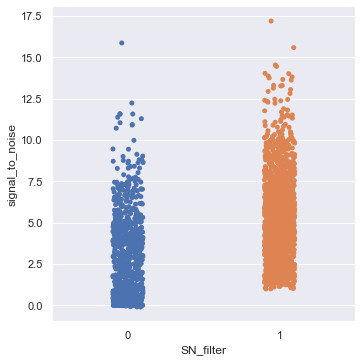

In [8]:
sns.catplot(
    data=train,
    x="SN_filter",y="signal_to_noise",
)
print("Graph")

Clustering

In [9]:
def compute_seq_distance_matrix(df):
    seq_len=len(df['sequence'][0])
    return np.column_stack([[1-lev.distance(seq_i,seq_j)/seq_len for seq_j in df['sequence']] for i,seq_i in enumerate(df['sequence'])])
distances=compute_seq_distance_matrix(clean_train)

In [10]:
linkage='complete'
threshold=.5
clustering = AgglomerativeClustering(None,affinity='precomputed',linkage=linkage,distance_threshold=threshold).fit(distances)
clean_train['cluster']=clustering.labels_

In order to compute the window size we set 10*features=data_points for a given window size. window size effects both the number of independent data points and the number of features.

We incorrectly computed the following, which did not acount for one-hot encoding
(2x+1)*(10x^2+65x+105)-((RNA'S)*68)=0 with x= window_size and (2x+1) is no overlap between data points
x~15

The correct form is
#(2x+1)*(160x^2+1720x+2310)-((RNA'S)*68)=0 with x= window_size and (2x+1) is no overlap between data points 
x~4

In [23]:
window_size=8
rna_alphabet=['G','U','A','C']
loop_alphabet=['S','M','I','B','H','E','X'] #From the bpRNA_documentation: S: paired "Stem" M: Multiloop I: Internal loop B: Bulge H: Hairpin loop E: dangling End X: eXternal loop

def structure_dict(text):   
    istart = []  # stack of indices of opening parentheses
    d = {}

    for i, character in enumerate(text):
        if character == '(':
             istart.append(i)
        if character == ')':
            try:
                start_index=istart.pop()
                d[start_index] = i
                d[i]=start_index
            except IndexError:
                print('Too many closing parentheses')
    if istart:  # check if stack is empty afterwards
        print('Too many opening parentheses')
    return d    

def create_encoder():
    nucleotide_window_cat=[rna_alphabet for i in range(2*window_size+1)]  #We have to specify the rna_alphabet for each nucletide in our window,
    paired_nucleotide_cat=[rna_alphabet+['Unpaired']]
    predicted_loop_type_cat=[loop_alphabet]
    
    all_categories=nucleotide_window_cat+paired_nucleotide_cat+predicted_loop_type_cat

    enc=OneHotEncoder(categories=all_categories,handle_unknown='ignore') # handle_unknown will convert the N/A padding to the zero vector
    enc.fit([['A' for i in range(2*window_size+2)]+['S']]) #Not sure why this is needed since we specify categories, but here we fit with dummy data
    return enc

def generate_numerical_data(rna,index,struct_dict):
    left_nucleotides=index
    right_nucleotides=rna.seq_length-index-1
    rna_paired_nucleotides= rna.structure.count('(')*2
        
    window_start=max(0,index-window_size)
    window_end=min(rna.seq_length,index+window_size+1) #window_end is the index of the last elt of the window plus one (for slice indexing)
    
    window_paired_nucleotides= len(re.findall(r'\(|\)', rna.structure[window_start:window_end]))
    
    loop_type_regex=rna.predicted_loop_type[index]+'+'
    left_size_of_loop_type= len(re.findall(loop_type_regex, rna.predicted_loop_type[:index+1])[-1])-1
    right_size_of_loop_type= len(re.findall(loop_type_regex, rna.predicted_loop_type[index:])[0])-1
    
    min_size_of_loop_type=min(left_size_of_loop_type,right_size_of_loop_type)
    max_size_of_loop_type=max(left_size_of_loop_type,right_size_of_loop_type)
    
    distance_to_bonded= abs(index-struct_dict.get(index,index))
    
    return [left_nucleotides,right_nucleotides,rna_paired_nucleotides,window_paired_nucleotides,min_size_of_loop_type,max_size_of_loop_type,distance_to_bonded]
    
def generate_raw_categorical_data(rna,seq_list,struct_dict,index):
    
    #seq_list has been buffered with N/A at the begining, so we need to shift index by window_size    
    shifted_index=index+window_size
    nucleotide_window=seq_list[(shifted_index-window_size):(shifted_index+window_size+1)] 
    
    paired_nucleotide = rna.sequence[pair_index] if (pair_index := struct_dict.get(index)) else 'Unpaired'
        
    predicted_loop_type=rna.predicted_loop_type[index]
    
    return nucleotide_window+[paired_nucleotide]+[predicted_loop_type]

def transform_rna_df(df,seq_len_col,poly_deg=0):
    enc=create_encoder()
    raw_data=scipy.sparse.vstack(df.apply(lambda rna: transform_rna(rna,seq_len_col,enc),axis=1))
    if poly_deg <2:
        return raw_data
    else:
        poly = PolynomialFeatures(poly_deg,interaction_only=True)
        return poly.fit_transform(raw_data)

def transform_labels_df(df):
    col_names=['id','index','cluster'] + [measurment for measurment,_ in measurments.values()]
    label_df= pd.DataFrame(np.vstack(df.apply(transform_labels,axis=1)),columns= col_names)
    
    label_df[col_names[1:]]=label_df[col_names[1:]].apply(pd.to_numeric)
    return label_df
    
def transform_rna(rna,seq_len_col,enc=None):
    if not enc:
        enc=create_encoder()

    struct_dict=structure_dict(rna.structure)
    seq_list=['N/A' for i in range(window_size)]+list(rna.sequence)+['N/A' for i in range(window_size)] #pad the sequence with N/A in case our window size goes beyond the end of the RNA
    
    numerical_data=[generate_numerical_data(rna,index,struct_dict) for index in range(rna[seq_len_col])]
    one_hot_data=enc.transform([generate_raw_categorical_data(rna,seq_list,struct_dict,index) for index in range(rna[seq_len_col])] ) 
    return scipy.sparse.hstack([numerical_data,one_hot_data])

def transform_labels(rna):
    return [[rna.id]+[str(index)]+[rna.cluster]+[rna[measurment][index] for measurment,_ in measurments.values()] for index in range(rna.seq_scored)]


Compute and add weights (from the clustering) to the expanded training data

In [12]:
def weight_labels(df,expanded_df):
    for measurment_filter in measurments:
        measure_name,_=measurments[measurment_filter]
        expanded_df[measure_name+'_weights']=compute_weights(df,expanded_df,measurment_filter)
    return expanded_df

def compute_weights(df,expanded_df,measurment_filter):
    filtered_df=df[df[measurment_filter]==True]
    cluster_dict=filtered_df['cluster'].value_counts()
    return np.where(expanded_df['id'].isin(filtered_df.id),(1/expanded_df['cluster'].map(cluster_dict)),0)

Kfold cross Val

In [13]:
def get_filtered_weighted_kfold_data(train_data,train_labels,target,folds):
    target_weights=target+'_weights'
    weight_filter=train_labels[target_weights] != 0

    filtered_train_data=train_data[weight_filter]
    filtered_train_labels=train_labels[weight_filter]

    group_kfold=GroupKFold(n_splits=folds)
    cv=group_kfold.split(filtered_train_data,filtered_train_labels[target],groups=filtered_train_labels['cluster'])
    return filtered_train_data,filtered_train_labels[target],filtered_train_labels[target_weights],cv    

Expand the training data from a row per RNA to a row per nucleotide (per RNA). We go from #RNA rows to #RNA*Length_of_the_RNA rows

In [24]:
train_data=transform_rna_df(clean_train,'seq_scored',2)
train_labels=weight_labels(clean_train,transform_labels_df(clean_train))

Train Regression models

In [25]:
alphas=[.01,.1,1,10]
folds=5

def fitted_regression(train_data,train_labels,target,validation=True,alpha=0):
    train,labels,weights,cv=get_filtered_weighted_kfold_data(train_data,train_labels,target,folds)
    if validation:
        reg=RidgeCV(alphas=alphas,normalize=True,cv=cv,scoring='neg_root_mean_squared_error')
        reg.fit(train,labels,weights)
    else:
        reg=Ridge(alpha=alpha,normalize=True)
        reg.fit(train,labels,weights)
    return reg



CV ridge reg models

In [ ]:
reactivity_reg=fitted_regression(train_data,train_labels,'reactivity')
deg_Mg_pH10_reg=fitted_regression(train_data,train_labels,'deg_Mg_pH10')
deg_pH10_reg=fitted_regression(train_data,train_labels,'deg_pH10')
deg_Mg_50C_reg=fitted_regression(train_data,train_labels,'deg_Mg_50C')
deg_50C_reg=fitted_regression(train_data,train_labels,'deg_50C')
cv_reg_models={'reactivity':reactivity_reg,'deg_Mg_pH10':deg_Mg_pH10_reg,'deg_pH10':deg_pH10_reg,'deg_Mg_50C':deg_Mg_50C_reg,'deg_50C':deg_50C_reg}


Train models on all training data

In [28]:
alphas={'reactivity':.01,'deg_Mg_pH10':.01,'deg_pH10':.01,'deg_Mg_50C':.01,'deg_50C':.01}
full_reg_models={key: fitted_regression(train_data,train_labels,key,validation=False,alpha=alpha) for key,alpha in alphas.items()}

Predict the test data (with regression) and save to csv

In [ ]:
def predict_and_save(df,model_dict,filename):
    expanded_df=transform_rna_df(df,'seq_length',2)
    predictions={key:model.predict(expanded_df) for key, model in model_dict.items()}
    df_pred=pd.DataFrame(predictions,index=[f'{row.id}_{i}' for index,row in df.iterrows() for i in range(row.seq_length)])
    df_pred.to_csv('Predictions/'+filename,index_label='id_seqpos')
predict_and_save(test,full_reg_models,'8regression.csv')

RNN data setup

In [13]:
def string_to_numerical_list(string,alphabet):
    hash_table = {k: v for v, k in enumerate(alphabet)}
    return [hash_table.get(elt,-1) for elt in string]

def transform_rnn_rna(rna):
    sequence_oh=keras.utils.to_categorical(string_to_numerical_list(rna.sequence,rna_alphabet),num_classes=len(rna_alphabet))
    loop_oh=keras.utils.to_categorical(string_to_numerical_list(rna.predicted_loop_type,loop_alphabet),num_classes=len(loop_alphabet))
    
    struct_dict=structure_dict(rna.structure)
    struct_list=np.array([struct_dict.get(i,-1)+1 for i in range(rna['seq_length'])])
    normalized_struct_list=struct_list/rna['seq_length']
    return np.hstack([normalized_struct_list.reshape(-1,1),sequence_oh,loop_oh])

def transform_rnn_df(df):
    return np.stack(df.apply(lambda rna: transform_rnn_rna(rna),axis=1),axis=2).transpose((2,0,1))


As with lin reg. we expand the training data from a row per RNA to a row per nucleotide (per RNA). We go from #RNA rows to #RNA*Length_of_the_RNA rows

In [14]:
train_data=transform_rnn_df(clean_train)
train_labels=weight_labels(clean_train,transform_labels_df(clean_train))

Filter out data, shape the data in to the correct form for keras (including padding out the unknown labels and weighing them 0), and finally split into cv

In [15]:
def get_labels_and_weights_rnn(train_labels,target,seq_length,seq_scored):
    #Here we add dummy 0s for the unmeasured/unscored nucleotides (to each rna_id) along with weighing them 0, then reshape into (batch_size,seq_len,)
    zeros=pd.Series(np.zeros(seq_length-seq_scored))
    labels_shaped=train_labels.groupby(by=['id'])[target].apply(lambda x: x.append(zeros)).to_numpy().reshape(-1,seq_length,1)
    weights_shaped=train_labels.groupby(by=['id'])[target+'_weights'].apply(lambda x: x.append(zeros)).to_numpy().reshape(-1,seq_length)
    return labels_shaped,weights_shaped


def rnn_filtering_validation_split(train_data,train_labels,target,folds=5,seq_length=107,seq_scored=68):
    target_weights=target+'_weights'
    nucleotide_weight_filter=train_labels[target_weights] != 0
    rna_weight_filter=train_labels.groupby(['id'])[target_weights].max()!=0


    filtered_train_data=train_data[rna_weight_filter]
    filtered_train_labels=train_labels[nucleotide_weight_filter]
    groups=filtered_train_labels.groupby(['id'])['cluster'].max()

    filtered_shaped_labels,filtered_shaped_weights=get_labels_and_weights_rnn(filtered_train_labels,target,seq_length,seq_scored)

    group_kfold=GroupKFold(n_splits=folds)
    cv=group_kfold.split(filtered_train_data,filtered_shaped_labels,groups=groups)
    return filtered_train_data,filtered_shaped_labels,filtered_shaped_weights,cv


Model details

In [325]:
def build_rnn(feature_dim,target='nameless'):
    seq_length=None #For variable length sequences
    rnn_dim=110
    dense_dim=rnn_dim
    
    inputs = keras.Input(shape=(seq_length,feature_dim))
    

    rnn_layer=keras.layers.Bidirectional(keras.layers.GRU(rnn_dim,recurrent_dropout=.1,return_sequences=True))
    dense_layer=keras.layers.Dense(dense_dim,activation='relu')
    outputs=keras.layers.Dense(1)(keras.layers.Dropout(.2)(dense_layer(rnn_layer(inputs))))
    model = keras.Model(inputs=inputs, outputs=outputs, name=target+'_rnn')
    
    model.compile(
        loss='mse',
        optimizer="adam",
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    model.summary()
    return model
def fit_model(model,train_data,target,validation=True):
    batch_size=64
    epochs=110
    
    seq_length=107
    seq_scored=68
    
    data,labels,weights,cv=rnn_filtering_validation_split(train_data,train_labels,target)
    if validation:
        train_ind,val_ind=next(cv)
        val_data=(data[val_ind],labels[val_ind],weights[val_ind])
        return model.fit(data[train_ind], labels[train_ind], batch_size=batch_size,sample_weight=weights[train_ind],validation_data=val_data, epochs=epochs)
    else:
        return model.fit(data, labels, batch_size=batch_size,sample_weight=weights,epochs=epochs)


Train and tweak a specific model

In [49]:
measure='reactivity'
model=build_rnn(train_data.shape[2],measure)
history=fit_model(model,train_data,measure)

Model: "reactivity_rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, None, 12)]        0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, None, 220)         81840     
_________________________________________________________________
dense_28 (Dense)             (None, None, 110)         24310     
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 110)         0         
_________________________________________________________________
dense_29 (Dense)             (None, None, 1)           111       
Total params: 106,261
Trainable params: 106,261
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
26/26 [==============================] - 19s 517ms/step - loss: 0.2088 - root_mean_squared_error: 0.

26/26 [==============================] - 12s 445ms/step - loss: 0.1093 - root_mean_squared_error: 0.1923 - val_loss: 0.1080 - val_root_mean_squared_error: 0.1884
Epoch 43/100
26/26 [==============================] - 12s 446ms/step - loss: 0.1105 - root_mean_squared_error: 0.1927 - val_loss: 0.1076 - val_root_mean_squared_error: 0.1876
Epoch 44/100
26/26 [==============================] - 12s 451ms/step - loss: 0.1081 - root_mean_squared_error: 0.1893 - val_loss: 0.1071 - val_root_mean_squared_error: 0.1868
Epoch 45/100
26/26 [==============================] - 12s 445ms/step - loss: 0.1073 - root_mean_squared_error: 0.1880 - val_loss: 0.1067 - val_root_mean_squared_error: 0.1860
Epoch 46/100
26/26 [==============================] - 12s 447ms/step - loss: 0.1074 - root_mean_squared_error: 0.1879 - val_loss: 0.1066 - val_root_mean_squared_error: 0.1858
Epoch 47/100
26/26 [==============================] - 12s 445ms/step - loss: 0.1059 - root_mean_squared_error: 0.1847 - val_loss: 0.1074 -

Epoch 89/100
26/26 [==============================] - 12s 448ms/step - loss: 0.0954 - root_mean_squared_error: 0.1668 - val_loss: 0.1002 - val_root_mean_squared_error: 0.1747
Epoch 90/100
26/26 [==============================] - 12s 444ms/step - loss: 0.0965 - root_mean_squared_error: 0.1669 - val_loss: 0.0994 - val_root_mean_squared_error: 0.1733
Epoch 91/100
26/26 [==============================] - 12s 446ms/step - loss: 0.0974 - root_mean_squared_error: 0.1681 - val_loss: 0.1006 - val_root_mean_squared_error: 0.1753
Epoch 92/100
26/26 [==============================] - 12s 446ms/step - loss: 0.0951 - root_mean_squared_error: 0.1663 - val_loss: 0.0993 - val_root_mean_squared_error: 0.1732
Epoch 93/100
26/26 [==============================] - 12s 444ms/step - loss: 0.0951 - root_mean_squared_error: 0.1661 - val_loss: 0.1002 - val_root_mean_squared_error: 0.1748
Epoch 94/100
26/26 [==============================] - 12s 444ms/step - loss: 0.0956 - root_mean_squared_error: 0.1661 - val_l

Training acc over epochs

<AxesSubplot:>

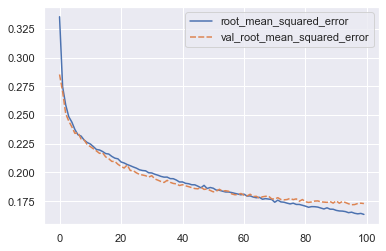

In [50]:
hdf=pd.DataFrame(history.history).loc[:,['root_mean_squared_error','val_root_mean_squared_error']]
sns.lineplot(data=hdf)


Train all models and store in dictionary

In [327]:
def fit_and_build(measurment,df):
    model=build_rnn(df.shape[2],measurment)
    history=fit_model(model,df,measurment,validation=False)
    return model
model_dict={measurment: fit_and_build(measurment,train_data) for measurment,_ in measurments.values()}

Model: "reactivity_rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, None, 12)]        0         
_________________________________________________________________
bidirectional_25 (Bidirectio (None, None, 220)         81840     
_________________________________________________________________
dense_44 (Dense)             (None, None, 110)         24310     
_________________________________________________________________
dropout_20 (Dropout)         (None, None, 110)         0         
_________________________________________________________________
dense_45 (Dense)             (None, None, 1)           111       
Total params: 106,261
Trainable params: 106,261
Non-trainable params: 0
_________________________________________________________________
Epoch 1/110
32/32 [==============================] - 19s 432ms/step - loss: 0.1893 - root_mean_squared_error: 0.

31/31 [==============================] - 18s 569ms/step - loss: 0.1585 - root_mean_squared_error: 0.2766
Epoch 12/110
31/31 [==============================] - 18s 570ms/step - loss: 0.1548 - root_mean_squared_error: 0.2701
Epoch 13/110
31/31 [==============================] - 18s 573ms/step - loss: 0.1548 - root_mean_squared_error: 0.2700
Epoch 14/110
31/31 [==============================] - 18s 569ms/step - loss: 0.1536 - root_mean_squared_error: 0.2684
Epoch 15/110
31/31 [==============================] - 18s 570ms/step - loss: 0.1491 - root_mean_squared_error: 0.2619
Epoch 16/110
31/31 [==============================] - 18s 568ms/step - loss: 0.1489 - root_mean_squared_error: 0.2600
Epoch 17/110
31/31 [==============================] - 17s 565ms/step - loss: 0.1480 - root_mean_squared_error: 0.2585
Epoch 18/110
31/31 [==============================] - 18s 566ms/step - loss: 0.1467 - root_mean_squared_error: 0.2549
Epoch 19/110
31/31 [==============================] - 18s 568ms/step 

26/26 [==============================] - 15s 590ms/step - loss: 0.1334 - root_mean_squared_error: 0.2275
Epoch 31/110
26/26 [==============================] - 15s 591ms/step - loss: 0.1355 - root_mean_squared_error: 0.2307
Epoch 32/110
26/26 [==============================] - 15s 590ms/step - loss: 0.1343 - root_mean_squared_error: 0.2285
Epoch 33/110
26/26 [==============================] - 15s 589ms/step - loss: 0.1352 - root_mean_squared_error: 0.2292
Epoch 34/110
26/26 [==============================] - 15s 591ms/step - loss: 0.1319 - root_mean_squared_error: 0.2242
Epoch 35/110
26/26 [==============================] - 15s 592ms/step - loss: 0.1347 - root_mean_squared_error: 0.2295
Epoch 36/110
26/26 [==============================] - 15s 591ms/step - loss: 0.1330 - root_mean_squared_error: 0.2272
Epoch 37/110
26/26 [==============================] - 15s 594ms/step - loss: 0.1335 - root_mean_squared_error: 0.2269
Epoch 38/110
26/26 [==============================] - 16s 592ms/step 

27/27 [==============================] - 16s 577ms/step - loss: 0.1140 - root_mean_squared_error: 0.1969
Epoch 50/110
27/27 [==============================] - 16s 583ms/step - loss: 0.1139 - root_mean_squared_error: 0.1962
Epoch 51/110
27/27 [==============================] - 16s 579ms/step - loss: 0.1125 - root_mean_squared_error: 0.1942
Epoch 52/110
27/27 [==============================] - 16s 575ms/step - loss: 0.1136 - root_mean_squared_error: 0.1960
Epoch 53/110
27/27 [==============================] - 15s 569ms/step - loss: 0.1129 - root_mean_squared_error: 0.1933
Epoch 54/110
27/27 [==============================] - 15s 572ms/step - loss: 0.1141 - root_mean_squared_error: 0.1965
Epoch 55/110
27/27 [==============================] - 15s 573ms/step - loss: 0.1137 - root_mean_squared_error: 0.1966
Epoch 56/110
27/27 [==============================] - 15s 568ms/step - loss: 0.1109 - root_mean_squared_error: 0.1922
Epoch 57/110
27/27 [==============================] - 15s 568ms/step 

Epoch 1/110
27/27 [==============================] - 21s 580ms/step - loss: 0.2338 - root_mean_squared_error: 0.3991
Epoch 2/110
27/27 [==============================] - 16s 606ms/step - loss: 0.1672 - root_mean_squared_error: 0.2847
Epoch 3/110
27/27 [==============================] - 16s 604ms/step - loss: 0.1534 - root_mean_squared_error: 0.2617
Epoch 4/110
27/27 [==============================] - 16s 606ms/step - loss: 0.1490 - root_mean_squared_error: 0.2529
Epoch 5/110
27/27 [==============================] - 16s 606ms/step - loss: 0.1465 - root_mean_squared_error: 0.2470
Epoch 6/110
27/27 [==============================] - 16s 607ms/step - loss: 0.1410 - root_mean_squared_error: 0.2403
Epoch 7/110
27/27 [==============================] - 16s 611ms/step - loss: 0.1418 - root_mean_squared_error: 0.2404
Epoch 8/110
27/27 [==============================] - 16s 608ms/step - loss: 0.1372 - root_mean_squared_error: 0.2329
Epoch 9/110
27/27 [==============================] - 16s 608ms/s

Predict off of model_dict from above, and save results to rnn.csv

In [328]:
def transform_and_predict(df,model):
    return model.predict(transform_rnn_df(df)).reshape(-1,df['seq_length'].max())
def predict_and_save_rnn(df,models,filename='rnn.csv'):
    copied_df=df.copy()
    groupedby=copied_df.groupby('seq_length')
    
    for measurment,model in models.items():
        grouped_predictions=groupedby.apply(lambda df: transform_and_predict(df,model))
        indexed_predictions=[pd.DataFrame(groupedby.indices[seq_len],columns=['orig_index']).join(pd.DataFrame({measurment: [row for row in grouped_predictions.loc[seq_len]]})) for seq_len in groupedby.indices]
        stacked_indexed_predictions=pd.concat(indexed_predictions,axis=0)
        copied_df=copied_df.merge(stacked_indexed_predictions,left_on='index',right_on='orig_index').drop(['orig_index'],axis=1)

    df_pred=pd.DataFrame({measurment: np.concatenate(copied_df[measurment]) for measurment in models.keys()},index=[f'{row.id}_{i}' for index,row in copied_df.iterrows() for i in range(row.seq_length)])
    df_pred.to_csv('Predictions/'+filename,index_label='id_seqpos')
predict_and_save_rnn(test,model_dict)

Save models

In [331]:
for key, model in model_dict.items():
    model.save('Models/'+key)

INFO:tensorflow:Assets written to: Models/reactivity\assets
INFO:tensorflow:Assets written to: Models/deg_Mg_pH10\assets
INFO:tensorflow:Assets written to: Models/deg_pH10\assets
INFO:tensorflow:Assets written to: Models/deg_Mg_50C\assets
INFO:tensorflow:Assets written to: Models/deg_50C\assets


Expand data with categorical data (without one hots) for random forest

In [21]:
def transform_rna_df_rf(df,seq_len_col):
    cols=['left_nucleotides','right_nucleotides','rna_paired_nucleotides','window_paired_nucleotides','min_size_of_loop_type','max_size_of_loop_type','distance_to_bonded'] + [f'{i-window_size}_pos' for i in range(2*window_size+1)]+['paired_nucleotide','predicted_loop_type']
    return pd.DataFrame(np.vstack(df.apply(lambda rna: transform_rna_rf(rna,seq_len_col),axis=1)),columns=cols)
    
def transform_rna_rf(rna,seq_len_col):
    struct_dict=structure_dict(rna.structure)
    seq_list=['N/A' for i in range(window_size)]+list(rna.sequence)+['N/A' for i in range(window_size)] #pad the sequence with N/A in case our window size goes beyond the end of the RNA
    return [generate_numerical_data(rna,index,struct_dict) + generate_raw_categorical_data(rna,seq_list,struct_dict,index) for index in range(rna[seq_len_col])]


Process data and save to send to R as scikitlearn does not use categorical data in random forests without one-hot

In [283]:
train_data_rf=transform_rna_df_rf(clean_train,'seq_scored')
train_labels=weight_labels(clean_train,transform_labels_df(clean_train))
combined_data=pd.concat([train_labels,train_data_rf],axis=1)
combined_data.to_csv('Processed_Data/10rna.csv')

In [285]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140488 entries, 0 to 140487
Data columns (total 43 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         140488 non-null  object 
 1   index                      140488 non-null  int64  
 2   cluster                    140488 non-null  int64  
 3   reactivity                 140488 non-null  float64
 4   deg_Mg_pH10                140488 non-null  float64
 5   deg_pH10                   140488 non-null  float64
 6   deg_Mg_50C                 140488 non-null  float64
 7   deg_50C                    140488 non-null  float64
 8   reactivity_weights         140488 non-null  float64
 9   deg_Mg_pH10_weights        140488 non-null  float64
 10  deg_pH10_weights           140488 non-null  float64
 11  deg_Mg_50C_weights         140488 non-null  float64
 12  deg_50C_weights            140488 non-null  float64
 13  left_nucleotides           14

In [22]:
test_data_rf=transform_rna_df_rf(test,'seq_length')
pd.concat([pd.DataFrame([f'{row.id}_{i}' for index,row in test.iterrows() for i in range(row.seq_length)],columns=['id_seqpos']),test_data_rf],axis=1).to_csv('Processed_Data/10test_rna.csv')

In [3]:
df=pd.read_csv('Predictions/randomforest.csv')
df.drop(['Unnamed: 0'],axis=1).to_csv('Predictions/formated_randomforest.csv',index=False)

Grid search for random forests, only supports one hots so not going to be used

In [141]:
folds=4
tuned_parameters={'n_estimators':[550],'max_features':[0.05,0.15,0.25,0.33,0.4],'min_samples_leaf':[3,5,10],'max_samples':[0.8]}
def grid_search_forest(train_data,train_labels,target):
    train,labels,weights,cv=get_filtered_weighted_kfold_data(train_data,train_labels,target,folds)
    clf=GridSearchCV(RandomForestRegressor(),tuned_parameters,cv=cv,verbose=5,n_jobs=-2,scoring='neg_root_mean_squared_error')
    clf.fit(train,labels,sample_weight= weights)
    return clf

#grid_reactivity=grid_search_forest(train_data,train_labels,'reactivity')


Baseline averages as prediction

In [241]:
train_labels=weight_labels(clean_train,transform_labels_df(clean_train))
averages={measurment:(train_labels[measurment]*train_labels[measurment+'_weights']).sum()/train_labels[measurment+'_weights'].sum() for measurment,_ in measurments.values()}
df_pred=pd.DataFrame(averages,index=[f'{row.id}_{i}' for index,row in test.iterrows() for i in range(row.seq_length)])
df_pred.to_csv('Predictions/averages.csv',index_label='id_seqpos')
